### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

2025-07-16 16:27:39.106595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752683259.305704      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752683259.359525      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Spectrogram Images & Labels
We load Mel spectrogram images from each genre folder, resize them to a uniform shape (224x224), and store their corresponding genre labels for further processing.

In [2]:
IMAGE_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original"

data = []
labels = []

print("Loading images...")
for genre in os.listdir(IMAGE_PATH):
    genre_folder = os.path.join(IMAGE_PATH, genre)
    print(f"Loading {genre} images...")
    
    for img_file in os.listdir(genre_folder):
        img_path = os.path.join(genre_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 for better performance
        data.append(img)
        labels.append(genre)

data = np.array(data)
labels = np.array(labels)

print(f"Loaded images: {data.shape}")

Loading images...
Loading disco images...
Loading metal images...
Loading reggae images...
Loading blues images...
Loading rock images...
Loading classical images...
Loading jazz images...
Loading hiphop images...
Loading country images...
Loading pop images...
Loaded images: (999, 224, 224, 3)


### Test Image per Genre
This section shows one unprocessed spectrogram image from each genre, taken directly from the original dataset (`/images_original`). These images visually represent the time-frequency energy distribution of music clips.

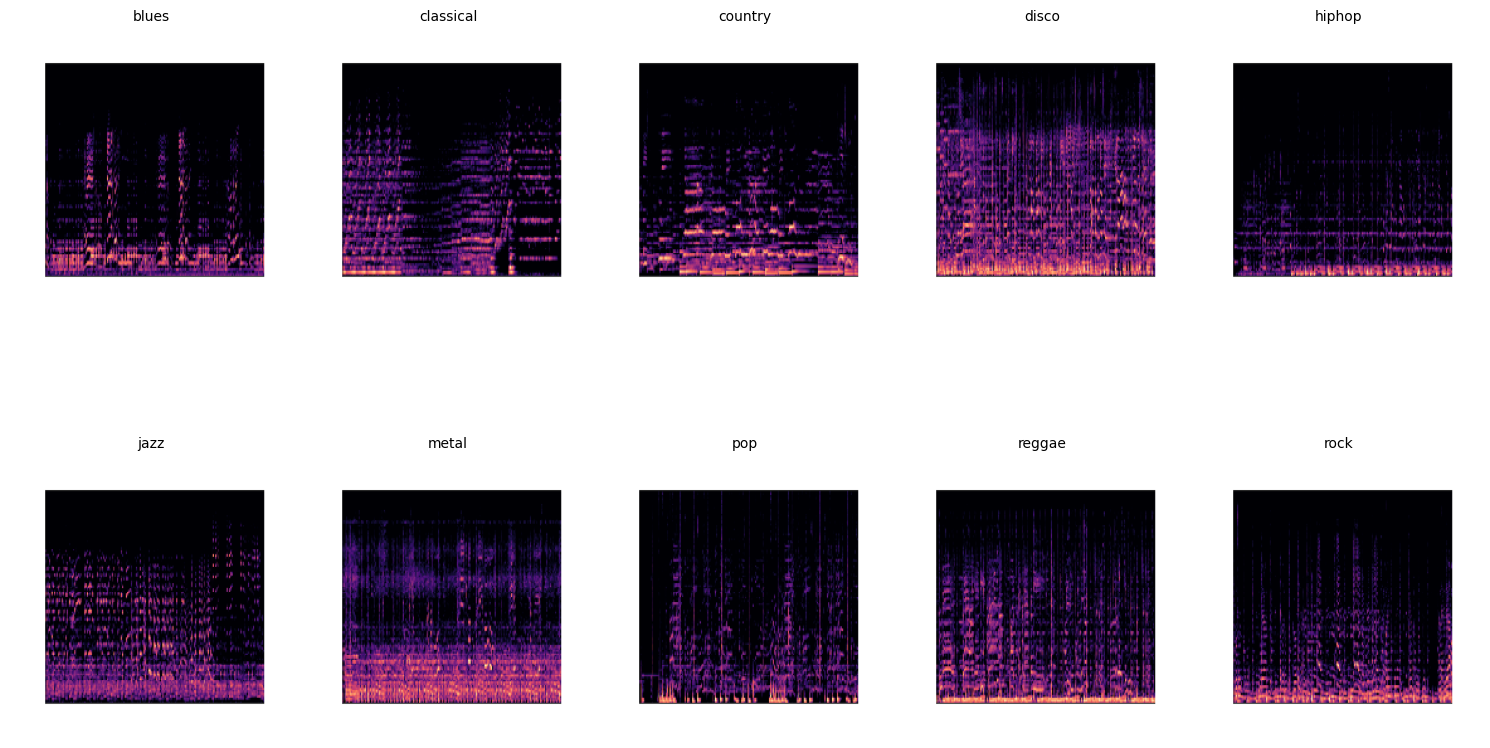

In [3]:
# Display one spectrogram image per genre
genres = sorted(os.listdir(IMAGE_PATH))  # Ensures consistent order
plt.figure(figsize=(15, 10))

for idx, genre in enumerate(genres):
    genre_folder = os.path.join(IMAGE_PATH, genre)
    sample_image = os.listdir(genre_folder)[0]  # First image in folder
    img_path = os.path.join(genre_folder, sample_image)

    # Load and convert BGR to RGB
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"{genre}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Preprocess Data
This section converts the image data to the correct format, applies EfficientNet-compatible preprocessing, encodes the string labels into numerical format, and splits the data into training, validation, and test sets.

In [4]:
X = data.astype('float32')  # Ensure float32
X = preprocess_input(X)     # Use MobileNetV2 preprocessing
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, stratify=y_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (699, 224, 224, 3)
Validation set: (150, 224, 224, 3)
Test set: (150, 224, 224, 3)


### Model Architecture - EfficientNetB0 Transfer Learning
We use EfficientNetB0 (pretrained on ImageNet) as a frozen feature extractor. A custom classifier is added on top to predict the genre from the extracted features.

In [5]:
# Load pre-trained EfficientNetB0 for feature extraction
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Extract features once using base_model.predict
train_features = base_model.predict(X_train, verbose=1)
val_features = base_model.predict(X_val, verbose=1)
test_features = base_model.predict(X_test, verbose=1)

# Build a simple classifier on top of the extracted features
model_effnet = Sequential([
    Flatten(input_shape=train_features.shape[1:]),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model_effnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
# model_effnet.summary()

I0000 00:00:1752683286.744325      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1752683293.760619      60 service.cc:148] XLA service 0x7e2fa4148430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752683293.761471      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752683294.457797      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

I0000 00:00:1752683299.239528      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


### Training - EfficientNetB0 Model
The model is trained using early stopping and checkpointing to prevent overfitting. The best model (based on validation loss) is saved for final evaluation.

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

# Train the model
hist_effnet = model_effnet.fit(
    train_features, y_train,
    validation_data=(val_features, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
loss_effnet, acc_effnet = model_effnet.evaluate(test_features, y_test, verbose=1)
print(f"\nEfficientNetB0 - Test Loss: {loss_effnet:.4f}")
print(f"EfficientNetB0 - Test Accuracy: {acc_effnet:.4f}")

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1960 - loss: 42.0805
Epoch 1: val_loss improved from inf to 6.09766, saving model to best_model.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.1989 - loss: 41.8103 - val_accuracy: 0.4800 - val_loss: 6.0977
Epoch 2/200
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4254 - loss: 10.5454
Epoch 2: val_loss improved from 6.09766 to 1.20710, saving model to best_model.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4283 - loss: 10.0199 - val_accuracy: 0.6467 - val_loss: 1.2071
Epoch 3/200
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5959 - loss: 1.4740
Epoch 3: val_loss improved from 1.20710 to 1.16181, saving model to best_model.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.5893 - loss: 1.4520 - val_accuracy: 0.6400 - val_loss: 1.1618
Epoch 4/200
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6092 - loss: 1.2157
Epoch 4: val_loss improved from 1.16181 to 1.07194, saving 

### Training History Visualization
Visualizes training and validation accuracy and loss curves across epochs to help understand learning dynamics and model convergence.

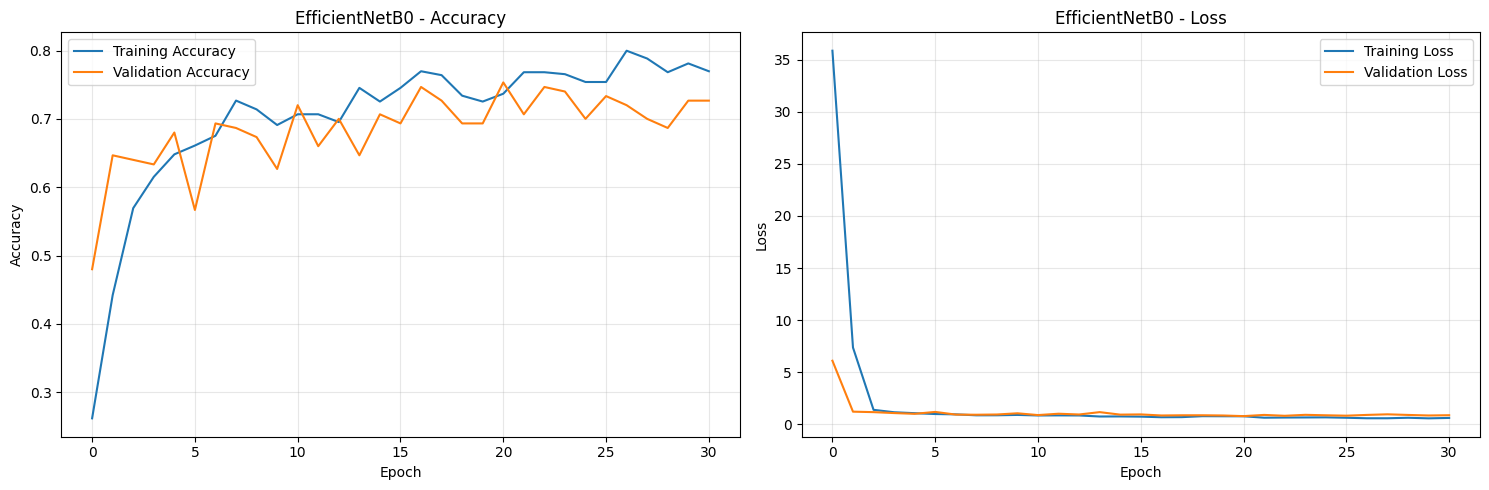

In [7]:
def plot_training_history(history, model_name):
    """
    Plot training and validation accuracy/loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(hist_effnet, 'EfficientNetB0')

### Detailed Model Evaluation
Performs detailed evaluation on the test set including a classification report, confusion matrix, and per-class accuracy to identify strengths and weaknesses of the model.


EfficientNetB0 - Detailed Evaluation

Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        15
   classical       0.86      0.80      0.83        15
     country       0.48      0.73      0.58        15
       disco       0.83      0.67      0.74        15
      hiphop       0.76      0.87      0.81        15
        jazz       0.73      0.73      0.73        15
       metal       0.92      0.80      0.86        15
         pop       0.60      0.60      0.60        15
      reggae       0.69      0.60      0.64        15
        rock       0.38      0.40      0.39        15

    accuracy                           0.68       150
   macro avg       0.70      0.68      0.68       150
weighted avg       0.70      0.68      0.68       150



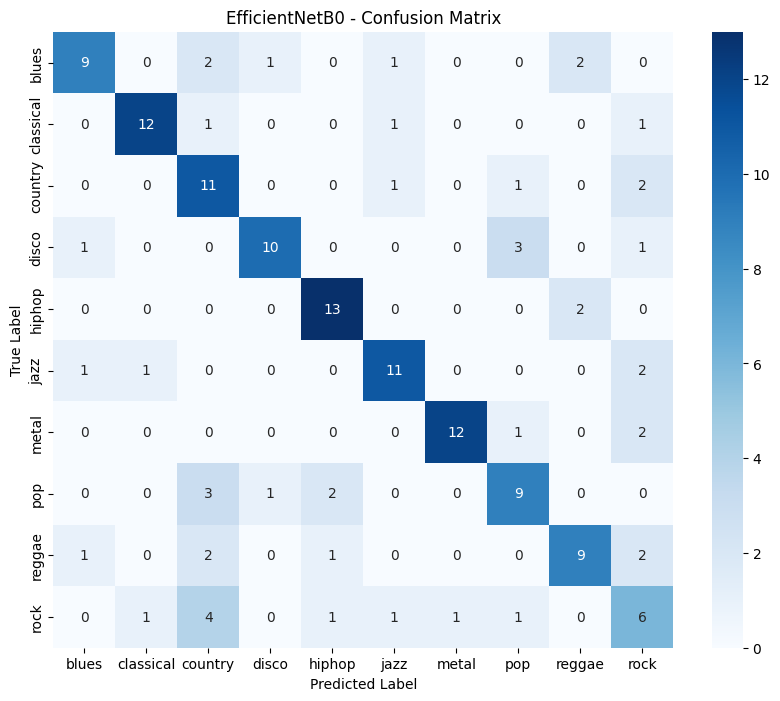


Per-class Accuracy:
    Genre  Accuracy
   hiphop  0.866667
classical  0.800000
    metal  0.800000
     jazz  0.733333
  country  0.733333
    disco  0.666667
    blues  0.600000
      pop  0.600000
   reggae  0.600000
     rock  0.400000


In [8]:
def detailed_evaluation(model, X_test, y_test, model_name, use_onehot=False):
    """
    Perform detailed evaluation including classification report and confusion matrix
    """
    print(f"\n{model_name} - Detailed Evaluation")
    print("=" * 50)
    
    # Get predictions
    y_pred = model.predict(X_test, verbose=0)
    
    if use_onehot:
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
    else:
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = y_test
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    class_acc_df = pd.DataFrame({
        'Genre': encoder.classes_,
        'Accuracy': per_class_acc
    }).sort_values('Accuracy', ascending=False)
    
    print(f"\nPer-class Accuracy:")
    print(class_acc_df.to_string(index=False))
    
    return y_pred_classes, y_true_classes

# Detailed evaluation
pred_effnet, true_effnet = detailed_evaluation(model_effnet, test_features, y_test,
                                               'EfficientNetB0', use_onehot=True)

### Save Models
Saves the trained model and label encoder to disk for reuse or deployment without retraining.

In [9]:
# Save the models
print("Saving models...")

# Save MobileNetV2 model
model_effnet.save("efficientnet_music_genre_model.h5")
print("EfficientNetB0 model saved as 'efficientnet_music_genre_model.h5'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

Saving models...
EfficientNetB0 model saved as 'efficientnet_music_genre_model.h5'
Label encoder saved as 'label_encoder.pkl'


### Final Results Summary
A summary of the dataset, genres, training configuration, model performance, and saved artifacts. Provides a high-level view of the entire experiment.

In [10]:
print(f"\nDataset Information:")
print(f"- Total samples: {len(data)}")
print(f"- Number of genres: {len(encoder.classes_)}")
print(f"- Genres: {', '.join(encoder.classes_)}")

print(f"\nModel Performance:")
print(f"- EfficientNetB0 Accuracy: {acc_effnet:.4f} ({acc_effnet*100:.2f}%)")

print(f"\nTraining Details:")
print(f"- EfficientNetB0 epochs: {len(hist_effnet.history['accuracy'])}")
print(f"- Data augmentation: Applied")
print(f"- Early stopping: Applied")

print("\nFiles saved:")
print("- efficientnet_music_genre_model.h5")
print("- label_encoder.pkl")


Dataset Information:
- Total samples: 999
- Number of genres: 10
- Genres: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock

Model Performance:
- EfficientNetB0 Accuracy: 0.6800 (68.00%)

Training Details:
- EfficientNetB0 epochs: 31
- Data augmentation: Applied
- Early stopping: Applied

Files saved:
- efficientnet_music_genre_model.h5
- label_encoder.pkl
